In [2]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn_pandas import DataFrameMapper
    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
    from sklearn.decomposition import PCA
    from sklearn.model_selection import GridSearchCV
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


* Al tener el Data Set repartido en 5 partes debemos unificar todo en un mismo DataFrame

In [3]:
# Leemos las 5 partes
dfs = [pd.read_csv(f'parte_{i}.csv') for i in range(1, 6)]

# Y las concatenamos en una unica variable "frauds"
frauds = pd.concat(dfs, ignore_index=True)

# Realizamos un chequeo de prueba
frauds.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
965636,44,TRANSFER,741596.98,C683958004,0.0,0.00,C686652833,1698793.12,2440390.10,0,0
3062412,234,CASH_OUT,192593.87,C1040714624,0.0,0.00,C1480872147,2343170.40,2535764.27,0,0
4213956,305,CASH_IN,378121.68,C670902813,1118.0,379239.68,C80575703,0.00,0.00,0,0
5771126,400,CASH_OUT,542401.55,C153913473,0.0,0.00,C1602318602,23490077.17,24032478.72,0,0
802801,40,CASH_IN,292036.00,C1872666530,45365.0,337401.00,C1903815642,3317454.11,3025418.11,0,0


# 1. Listado de variables y selección
### Variables de entrada:

* step : representa una unidad de tiempo en el mundo real. En este caso, 1 paso equivale a 1 hora de tiempo. El total de pasos es 744 (simulación de 30 días).

* type : ENTRADA, SALIDA, DÉBITO, PAGO y TRANSFERENCIA.

* amount : importe de la transacción en moneda local.

* nameOrig : cliente que inició la transacción

* oldbalanceOrg : saldo inicial antes de la transacción

* newbalanceOrig : new balance después de la transacción

* nameDest : cliente que es el destinatario de la transacción

* oldbalanceDest : destinatario del saldo inicial antes de la transacción. No hay información para los clientes que comienzan con M (comerciantes).

* newbalanceDest : destinatario del nuevo saldo después de la transacción. No hay información para los clientes que comienzan con M (comerciantes).

### Variable de salida:

* isFraud : son las transacciones realizadas por agentes fraudulentos dentro de la simulación. En este conjunto de datos específico, el comportamiento fraudulento de los agentes tiene como objetivo obtener ganancias tomando el control de las cuentas de los clientes e intentar vaciar los fondos transfiriéndolos a otra cuenta y luego sacándolos del sistema. Los valores posibles para esta variable son 0 y 1.

### Variable que no será utilizada:

* isFlaggedFraud : variable que intenta detectar intentos ilegales, existen solo 16 registros positivos en la misma por lo cual decidimos no utilizarla ya que no nos aporta ningun valor agregado. A continuación haremos una representacion de los valores donde esta variable es 1 para demostrar que la cantidad de registros es la anteriormente mencionada.


In [4]:
# Demostracion con valores en 1 con la variable isFlaggedFraud
frauds_isfraud = frauds[frauds['isFlaggedFraud'] > 0]

isfraudF = (frauds['isFlaggedFraud'] > 0).sum()
notfraudF = (frauds['isFlaggedFraud'] == 0).sum()

print(f'Número de transacciones marcadas como intento ilegal de transacciones: {isfraudF}')
print(f'Número de transacciones NO marcadas como intento ilegal de transacciones: {notfraudF}')

# Por lo que se procece a la eliminacion de la columna
frauds.drop('isFlaggedFraud', axis=1, inplace=True)

Número de transacciones marcadas como intento ilegal de transacciones: 16
Número de transacciones NO marcadas como intento ilegal de transacciones: 6362604


# 2. Análisis detallado de un conjunto de variables


### Para la variable de salida, explicar y graficar su distribución. Analizar posibles consecuencias o consideraciones a tener en cuenta.

Número de transacciones que son fraude: 8213
Número de transacciones que NO son fraude: 6354407


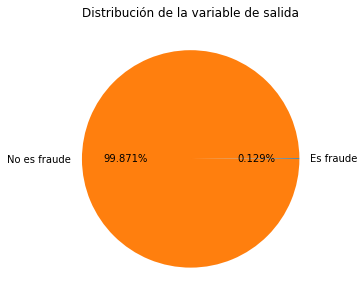

In [5]:

# tenemos la cantidad de registros con valores fraudes y la cantidad que no son fraude. Posteriormente reamos un gráfico de torta de la distribución de los valores positivos y negativos de nuestra variable de salida, mostrando los porcentajes con tres decimales para verificar el balanceo del dataset.
isfraud = (frauds['isFraud'] != 0).sum()
notfraud = (frauds['isFraud'] == 0).sum()

print(f'Número de transacciones que son fraude: {isfraud}')
print(f'Número de transacciones que NO son fraude: {notfraud}')

plt.figure(figsize=(5, 5))
plt.pie([isfraud, notfraud], labels=['Es fraude', 'No es fraude'], autopct='%1.3f%%')
plt.title('Distribución de la variable de salida')

plt.show()

El gráfico muestra el desbalanceo de la variable de salida "fraude" en el conjunto de datos. Como se puede observar, el número de transacciones fraudulentas (8213 instancias) es significativamente menor en comparación con el número de transacciones no fraudulentas (6,354,407 instancias). Esto indica un desbalance notable en el dataset, con una proporción muy baja de fraudes respecto al total de transacciones.

### Realizar un análisis individual de cada variable de entrada que será utilizada. A partir del mismo debería poder conocerse la distribución de los datos, si existen valores raros, su relación con la variable de salida, etc.

*  Relación entre las variables oldbalanceOrg, newbalanceOrig, oldbalanceDest y newbalanceDest.

In [6]:
# En una primera impresion notamos que hay varios casos en los que los cuatro balances de las cuentas de Origen y Destino son 0 (cero)
frauds_balance_cero = frauds[
                        (frauds['oldbalanceOrg'] == 0) &
                        (frauds['newbalanceOrig'] == 0) &
                        (frauds['oldbalanceDest'] == 0) &
                        (frauds['newbalanceDest'] == 0)
                      ]

frauds_balance_not_cero = frauds[
                        (frauds['oldbalanceOrg'] != 0) |
                        (frauds['newbalanceOrig'] != 0) |
                        (frauds['oldbalanceDest'] != 0) |
                        (frauds['newbalanceDest'] != 0)
                      ]

print('Cantidad de registros con los cuatro balances en 0: ',(len(frauds_balance_cero)))
print('Cantidad de registros con al menos un balance distinto de 0: ',(len(frauds_balance_not_cero)))

Cantidad de registros con los cuatro balances en 0:  774275
Cantidad de registros con al menos un balance distinto de 0:  5588345


*  Relación entre el tipo de transacción (type) y el fraude (isFraud)

Esta relacion muestra la cantidad de transacciones fraudulentas y no fraudulentas dentro de cada tipo de transacción, lo que permite una mejor comparación entre las categorías.

In [7]:
# TODO: encontrar algun grafico que refleje bien esta relación sino dejar la comparativa sola
#transaction_count = frauds.groupby(['type', 'isFraud']).size().unstack(fill_value=0)

# Renombramos las columnas para mayor claridad
#transaction_count.columns = ['No Fraude', 'Fraude']

#transaction_count.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])

#plt.title('Cantidad de Transacciones por Tipo y Estado de Fraude')
#plt.xlabel('Tipo de Transacción')
#plt.ylabel('Cantidad de Transacciones')
#plt.legend(['No Fraude', 'Fraude'], loc='upper right')

#plt.show()

# Contabilizamos la cantidad de transacciones fraudulentas y no fraudulentas por tipo
transaction_count = frauds.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
transaction_count.columns = ['No Fraude', 'Fraude']

for transaction_type in transaction_count.index:
    no_fraud = transaction_count.loc[transaction_type, 'No Fraude']
    fraud = transaction_count.loc[transaction_type, 'Fraude']
    print(f"Tipo de Transacción: {transaction_type}")
    print(f"  No Fraude: {no_fraud}")
    print(f"  Fraude: {fraud}\n")


Tipo de Transacción: CASH_IN
  No Fraude: 1399284
  Fraude: 0

Tipo de Transacción: CASH_OUT
  No Fraude: 2233384
  Fraude: 4116

Tipo de Transacción: DEBIT
  No Fraude: 41432
  Fraude: 0

Tipo de Transacción: PAYMENT
  No Fraude: 2151495
  Fraude: 0

Tipo de Transacción: TRANSFER
  No Fraude: 528812
  Fraude: 4097



* Relación entre el importe de la transacción (amount) y el fraude (isFraud)
<!--El objetivo acá es ver si los montos de las transacciones fraudulentas tienden a ser diferentes de los montos de las transacciones legítimas.

-La línea en el centro de la caja: Representa la mediana del amount para cada categoría (isFraud = 0 o 1).

-Los bordes de la caja: Representan el primer cuartil (Q1) y el tercer cuartil (Q3), lo que cubre el 50% de los valores centrales.-->

In [8]:
# TODO: encontrar grafico para poder explicar la relación

### Para cada una de las variables de entrada elegidas, explicar si se debería realizar o no alguna transformación para poder utilizarla como entrada de un modelo y por qué.

* ⁠step: No necesita transformacion ya que es numérica y representa tiempo en unidades discretas (horas).

* ⁠type: Si necesita transformacion, ya que es una variable categórica. La convertiremos en una representación numérica utilizando One-Hot Encoder creando una columna binaria para cada tipo de transacción. Luego de la ultima transformacion se agregaran 5 columnas (type_CASH_OUT, type_CASH_IN, type_PAYMENT, type_TRANSFER, type_DEBIT).

* ⁠amount: En principio consideramos que no sera necesario aplicar trasnformación ya que es una variable numérica. En caso de notar una gran disperción entre los valores, podríamos optar por una transformación para reducir dicha variabilidad y lograr estabilizar en el modelo.

* ⁠nameOrig: En principio esta columna no nos aporta información ya que creemos que es representativa del número de cuenta de cada cliente. Observamos que cada cuenta inicia con una letra diferente, lo que es representativo de un tipo de cliente. Como una Feature Engineering podríamos obtener que cantidad de veces participó en transacciones (sea de origen o destino) cada cliente. A modo de una mejor lectura se le cambiará el nombre por uno más estandarizado.

* ⁠oldbalanceOrg: En principio consideramos que no sera necesario aplicar trasnformación ya que es una variable numérica. El motivo es el mismo que para la variable amount. A modo de una mejor lectura se le cambiará el nombre por uno más estandarizado.

* ⁠newbalanceOrig: En principio consideramos que no sera necesario aplicar trasnformación ya que es una variable numérica. El motivo es el mismo que para la variable amount y oldbalanceOrg. A modo de una mejor lectura se le cambiará el nombre por uno más estandarizado.

* ⁠nameDest: Realizaremos la misma transformacion de la variable nameOrigin. Con la particularidad de que el cliente destino sea partícipe de una transacción fraudulenta (no es lo mismo ser autor de un fraude que ser una víctima). A modo de una mejor lectura se le cambiará el nombre por uno más estandarizado.

* ⁠oldbalanceDest: En principio consideramos que no sera necesario aplicar trasnformación ya que es una variable numérica. El motivo es el mismo que para la variable amount. A modo de una mejor lectura se le cambiará el nombre por uno más estandarizado.

* ⁠newbalanceDest: En principio consideramos que no sera necesario aplicar trasnformación ya que es una variable numérica. El motivo es el mismo que para la variable amount y oldbalanceDest. A modo de una mejor lectura se le cambiará el nombre por uno más estandarizado.

In [9]:
# Renombramos las columnas
BETTER_COLUMN_NAMES = {
    'step': 'step',
    'type': 'type',
    'amount': 'amount',
    'nameOrig': 'name_origin',
    'oldbalanceOrg': 'old_origin',
    'newbalanceOrig': 'new_origin',
    'nameDest': 'name_destination',
    'oldbalanceDest': 'old_destination',
    'newbalanceDest': 'new_destination',
    'isFraud': 'is_fraud',
}

frauds.rename(columns=BETTER_COLUMN_NAMES, inplace=True)

frauds.sample(5)

,step,type,amount,name_origin,old_origin,new_origin,name_destination,old_destination,new_destination,is_fraud
5758717,400,CASH_OUT,235875.01,C1032188899,2701.37,0.0,C232520531,2487632.08,2723507.09,0
4179263,304,CASH_OUT,92294.75,C1787651697,0.00,0.0,C1423245103,1120711.14,1213005.89,0
4491171,324,CASH_OUT,252426.03,C1396836577,0.00,0.0,C695277331,2127718.54,2380144.58,0
1924690,167,CASH_OUT,148510.94,C1694638319,109702.00,0.0,C424062754,0.00,148510.94,0
1243095,134,PAYMENT,8575.28,C1082886729,0.00,0.0,M1893583282,0.00,0.00,0


In [10]:
# # Ahora aplicamos One-Hot Encoder para los tipos de transacciones
# encoder = OneHotEncoder(dtype=int, sparse_output=False)

# # Aplicamos OneHotEncoder a la columna 'type'
# type_encoded = encoder.fit_transform(frauds[['type']])

# type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))

# # Eliminamos la columna 'type' para evitar datos redundantes
# frauds = frauds.drop(columns=['type'])

# # Y unimos las columnas nuevas al dataset original
# frauds = frauds.join(type_encoded_df)

# print(frauds.head())

### Analizar si las variables de entrada seleccionadas presentan valores nulos y/o extremos. En caso de encontrar dichas condiciones, indicar qué tratamiento se podría darle a las mismas y por qué.

* Comprobamos que no existen valores nulos en nuestro Data Set de la siguiente manera.

In [11]:
frauds.isnull().sum()

step                0
type                0
amount              0
name_origin         0
old_origin          0
new_origin          0
name_destination    0
old_destination     0
new_destination     0
is_fraud            0
dtype: int64

In [12]:
# Calculamos los extremos utilizando IQR para la columna 'amount'
Q1 = frauds['amount'].quantile(0.25)
Q3 = frauds['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_amount = frauds[(frauds['amount'] < lower_bound) | (frauds['amount'] > upper_bound)]

print(f"Cantidad de valores extremos detectados en 'amount': {outliers_amount.shape[0]}")

Cantidad de valores extremos detectados en 'amount': 338078


* En nuestro caso los valores extremos no deberían ser tratados de ninguna manera ya que son valores de transacciones que por el simple hecho de ser un monto transferido no se interpreta como una anomalía en los datos finales.

### Verificar si existen variables altamente correlacionadas linealmente. En dicho caso, explicar por qué considera que esto pasa.

<Axes: title={'center': 'Matriz de Correlación'}>

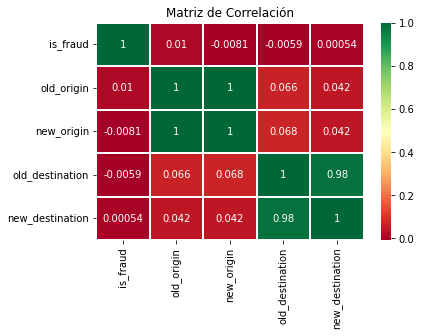

In [13]:
# Lo hacemos con las variables que son de tipo numérica en nuestro dataset y serán utilizadas para el modelo.

columnas_numericas = ['is_fraud', 'old_origin', 'new_origin', 'old_destination', 'new_destination' ]
plt.title('Matriz de Correlación')
sns.heatmap(frauds[columnas_numericas].corr(), annot=True, cmap='RdYlGn', linewidths=0.2)

In [14]:
# TODO: revisar relacion 1:1 con new_origin y old_origin

### Generar un listado de todas las posibles dudas/preguntas que quisieran realizarle al encargado de proveer los datos.

Algunas dudas o preguntas que nos surgieron mientras analizábamos los datos son: 

* ⁠Que significan los id que aparecen en las columnas name_origin y name_destination.
* ⁠Por que razón cuando se hace un cash_out la cuenta de origen y destino no es la misma.
* ⁠En muchos casos notamos que cuando se hace una transferencia no siempre el valor que se tenia en la cuenta propia disminuye, y no siempre el valor que se tenia en la cuenta de destino aumenta, ¿Por qué ocurriría esto?.
* ⁠En ciertos casos cuando el monto de la transferencia es mayor al valor que se tiene en la cuenta, se realiza la transferencia de todos modos y el valor en cuenta queda en 0.
* La variable isFlaggedFraud no coincide con la documentación, realmente se utiliza para algo o se creó para algo que al final no se implementó?.

# 3.⁠ ⁠Hipótesis sobre los datos

### Formular y describir de forma coloquial al menos una hipótesis sobre los datos que podría explicar el valor de la variable "target" bajo determinadas condiciones. Realizar un análisis para contrastar si dicha hipótesis se valida o, por el contrario, se refuta.

* Hipótesis 1: "Los registros en los que el saldo new_origin queda en 0 después de una transacción son propensos a ser fraudulentos."

* Descripción coloquial:
Se plantea que si el saldo del cliente que inició la transacción (new_origin) queda en 0 después de una transacción, es más probable que esa transacción sea fraudulenta. Esto podría deberse a que el supuesto atacante apunta a vaciar la cuenta del cliente.

In [16]:
frauds_new_origin_cero = frauds[(frauds['is_fraud'] == 1)]
frauds_new_origin_cero.sample(20)

,step,type,amount,name_origin,old_origin,new_origin,name_destination,old_destination,new_destination,is_fraud
6065042,509,CASH_OUT,23413.67,C1100198651,23413.67,0.00,C247352056,0.00,23413.67,1
4784096,336,TRANSFER,9207.38,C1777315934,9207.38,0.00,C44566269,0.00,0.00,1
6201899,581,TRANSFER,155002.83,C1691713014,155002.83,0.00,C71357990,0.00,0.00,1
6061807,501,TRANSFER,705647.68,C2091895045,705647.68,0.00,C1852963634,0.00,0.00,1
6020168,459,TRANSFER,1153156.00,C1788207069,1153156.00,0.00,C2113625922,0.00,0.00,1
5563740,388,CASH_OUT,680224.41,C2094995286,680224.41,0.00,C1259079602,1058527.77,1738752.19,1
6019704,456,TRANSFER,10000000.00,C1807237119,10585396.14,585396.14,C1910239392,0.00,0.00,1
584084,33,CASH_OUT,214975.90,C6796051,214975.90,0.00,C677541710,152331.28,374513.69,1
4718137,332,TRANSFER,19226.25,C56751982,19226.25,0.00,C2138523923,0.00,0.00,1
4388758,317,TRANSFER,681007.64,C1124786108,681007.64,0.00,C1894579301,0.00,0.00,1


Se puede apreciar que los 20 ejemplos de transacciones fraudulentas en el 100% de los mismos la columna 'new_origin' es 0, para apreciarlo en la totalidad de los datos mostramos la totalidad de los mismos

In [17]:
frauds_new_origin_cero = frauds[(frauds['is_fraud'] == 1) & (frauds['new_origin'] == 0)]
print('Cantidad de registros con new_origin es 0 luego de una transacción fraudulenta: ',len(frauds_new_origin_cero))

Cantidad de registros con new_origin es 0 luego de una transacción fraudulenta:  8053


De esta manera demostramos que nuestra primera hipótesis es válida.

* Hipótesis 2: "Las transacciones con importes mayores a 300.000 tienen una mayor probabilidad de ser fraudulentas."

* Descripción coloquial:
La idea es que, si una transacción tiene un importe significativamente alto, podría ser más propensa a ser fraudulenta. Esto podría ser porque los delincuentes prefieren realizar transacciones grandes para obtener mayores beneficios.

In [18]:
registers_high_amount = frauds[(frauds['amount'] > 300000)]
print('Cantidad de transacciones con valor mayor a $300.000: ',len(registers_high_amount))

frauds_high_amount = frauds[(frauds['amount'] > 300000) & (frauds['is_fraud'] == 1)]
print('Cantidad de transacciones fraudulentas con valor mayor a $300.000: ',len(frauds_high_amount))

Cantidad de transacciones con valor mayor a $300.000:  926257
Cantidad de transacciones fraudulentas con valor mayor a $300.000:  4789


Con estos resultados comprobamos que nuestra hipótesis 2 no se cumple ya que solo tenemos un 0.5% de transacciones fraudulentas con montos mayores a $300.000.

### Describa y presente cualquier otro hallazgo que sea capaz de encontrar en los datos. Explique el impacto que podría tener en la creación de un modelo.

* Análisis: Las transacciones fraudulentas se encuentran únicamente en los tipos CASH_OUT y TRANSFER. No se han detectado fraudes en las transacciones de tipo CASH_IN, DEBIT y PAYMENT.

* Impacto en la creación del modelo: 
Como modificación del modelo podríamos eliminar las columnas de CASH_IN, DEBIT y PAYMENT ya que no existen casos donde el modelo podría aprender ejemplos de fraude. Esto no se hará ya que eliminar esos tres tipos implica reducir nuestro dataset a un 35% del original.


##### Puntos que se tuvieron en cuenta a la hora de realizar este analisis
* Análisis del Data Set.
* Análisis de distribuciones.
* Análisis de correlación.
* Análisis de valores nulos.
* Análisis de datos faltantes.
* Exploración de variables categóricas.

Los ítems nombrados fueron detallados anteriormente con ejemplos y/o gráficos a modo de demostración.

### Analice si la creación de nuevas variables a partir de los datos existentes puede ser beneficiosa para el problema presentado.

Pensamos en generar una nueva columna llamada 'possible_fraud' que su posible valor sea 0 o 1 en nuestro data set y que tome el valor 1 para aquellos casos en el que la columna new_origin sea 0 y para aquellos casos en los que el new_origin sea distinto de 0 tome el valor 0.

In [19]:
frauds['possible_fraud'] = (frauds['new_origin'] == 0).astype(int)

print(frauds[['new_origin', 'possible_fraud']].head())


   new_origin  possible_fraud
0   160296.36               0
1    19384.72               0
2        0.00               1
3        0.00               1
4    29885.86               0


Con esta nueva Feature Engineering podemos agregar peso a la hora de entrenar nuestro modelo debido a que anteriormente descubrimos que los registros donde new_origin = 0 en un >95% de los casos se tratan de transacciones fraudulentas.

# 4.⁠ ⁠Modelado

* Aplicar alguna técnica de feature engineering para mejorar los datos de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.

* Realizar experimentos que utilicen como datos de entrada representaciones intermedias de los datos (generadas por técnicas de reducción de dimensiones como PCA). Compare los resultados obtenidos contra los casos previos, interprete y proponga conclusiones.

* En todo momento, se deben utilizar técnicas que garanticen que los modelos no están sobreentrenando.

* Determinar el valor final de la métrica que podría ser informado a un posible "cliente", utilizando técnicas que permitan obtener un valor lo más realista posible. Fundamentar y considerar no solo el rendimiento del modelo en su elección, sino también cuestiones como interpretabilidad, tiempos de entrenamiento, etc.

* Para el algoritmo seleccionado como "ganador", y para distintos pares de variables, genere diagramas de dispersión donde se visualicen los aciertos y errores del mismo. Discuta si existen patrones o conocimiento que se pueda obtener a partir de dichos errores. En caso de ser posible, evalúe la importancia que asigna el método a las variables de entrada y genere conclusiones al respecto.

Elegir una métrica de performance a utilizar para evaluar los modelos. Fundamentar la elección de la métrica.

In [20]:
frauds = frauds[
                        ((frauds['old_origin'] != 0) &
                        (frauds['new_origin'] != 0)) |
                        ((frauds['old_destination'] != 0) &
                        (frauds['new_destination'] != 0))]

frauds.shape

(4924896, 11)

In [21]:
#dropeamos algunas columnas

frauds = frauds.drop(columns=[ "possible_fraud","name_origin", "name_destination"])
frauds.sample(3)

,step,type,amount,old_origin,new_origin,old_destination,new_destination,is_fraud
5483789,379,CASH_OUT,121102.90,12137.0,0.00,556909.97,678012.87,0
1852222,164,CASH_OUT,155663.80,0.0,0.00,472348.29,628012.09,0
3375937,254,CASH_IN,68608.11,51302.0,119910.11,29420743.72,30388318.09,0


TODO: AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [22]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(frauds, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((2954937, 8), (984979, 8), (984980, 8))

In [23]:
# Definimos el mapper. Recibe una lista de (columna/s, transformers)
mapper = DataFrameMapper([
    (['step'], [StandardScaler()]),
    (['amount'], [StandardScaler()]),
    (['old_origin'], [StandardScaler()]),
    (['new_origin'], [StandardScaler()]),
    (['old_destination'], [StandardScaler()]),
    (['new_destination'], [StandardScaler()]),
    (['type'], [OneHotEncoder()])
])

# Lo entrenamos con train
mapper.fit(train)

DataFrameMapper(drop_cols=[],
                features=[(['step'], [StandardScaler()]),
                          (['amount'], [StandardScaler()]),
                          (['old_origin'], [StandardScaler()]),
                          (['new_origin'], [StandardScaler()]),
                          (['old_destination'], [StandardScaler()]),
                          (['new_destination'], [StandardScaler()]),
                          (['type'], [OneHotEncoder()])])

In [24]:
# vemos como transforma un sample:
sample = train.sample(5, random_state=42)

# Sample original:
sample

,step,type,amount,old_origin,new_origin,old_destination,new_destination,is_fraud
4382899,311,PAYMENT,17989.37,34286.00,16296.63,0.00,0.00,0
211058,13,CASH_OUT,367456.30,0.00,0.00,1177091.92,1544548.22,0
3943414,286,TRANSFER,1579719.20,39013.31,0.00,1643489.95,3223209.14,0
2330344,188,CASH_IN,87067.29,2286482.16,2373549.45,929605.52,842538.23,0
4653792,330,CASH_OUT,181633.11,0.00,0.00,1881460.67,2063093.78,0


In [25]:
mapper.transform(sample)

array([[ 0.48368828, -0.28342662, -0.32027867, -0.3316185 , -0.37375974,
        -0.37912695,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [-1.6082247 ,  0.24406434, -0.33084813, -0.33658278, -0.06385618,
        -0.00289891,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.30819222,  2.07387331, -0.31882136, -0.33658278,  0.05893661,
         0.40599691,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.37975231, -0.17915931,  0.37401372,  0.38644797, -0.12901415,
        -0.17389768,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61706528, -0.03642015, -0.33084813, -0.33658278,  0.1215893 ,
         0.12341077,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ]])

In [26]:
#mostramos los nombres de las columnas que genera el maper
mapper.transformed_names_

['step',
 'amount',
 'old_origin',
 'new_origin',
 'old_destination',
 'new_destination',
 'type_0',
 'type_1',
 'type_2',
 'type_3',
 'type_4']

In [27]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, frauds in enumerate(set_names):
        assert frauds in ['train', 'validation', 'test']
        set_data = globals()[frauds]  # <- hack feo...

        y = set_data.is_fraud
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['no_fraud', 'fraud'])
            cm_plot.plot(cmap="Blues")
            cm_plot.ax_.set_title(frauds)
        
    display(pd.DataFrame(final_metrics, index=set_names))


* Entrenar y evaluar al menos 3 algoritmos de machine learning distintos, realizando una exploración de hiper-parámetros mediante una búsqueda en grilla. Evaluar el comportamiento de cada modelo con los hiper-parámetros que mejores resultados ofrecen. En caso de ser posible, aporte conclusiones respecto a dicha comparación.

Modelo1: Regresión Logistica

In [70]:
lr_clf = LogisticRegression(random_state=42)
parameters = {
    'penalty': ['l2'],
    'C': [0.1, 1.0, 10.0]
}
grid_search = GridSearchCV(lr_clf, parameters,scoring = 'f1', refit=True, verbose=1)
lr_model = Pipeline([
    ('mapper', mapper),
    ('classifier', grid_search),
])

lr_model.fit(train, train.is_fraud)

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Puntuación media en el conjunto de validación:")
print(grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Mejores parámetros encontrados:
{'C': 10.0, 'penalty': 'l2'}
Puntuación media en el conjunto de validación:
0.5221643930948051


In [71]:
y_pred = lr_model.predict(validation)
metrics.f1_score(validation.is_fraud, y_pred)   

np.float64(0.5464725643896976)

'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.999618,0.955966,0.379797,0.543619
validation,0.999589,0.979920,0.378882,0.546473


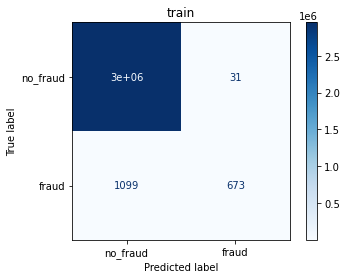

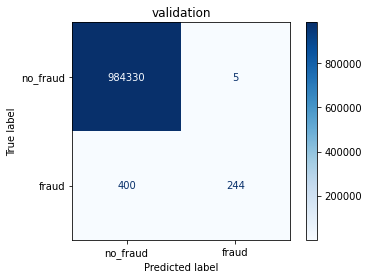

In [72]:
evaluate_model(lr_model, title='LR Simple Imputer', show_cm=True)

modelo 2: KNN

In [74]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
parameters = {'n_neighbors': [3, 5, 7, 11],              
              'weights': ['distance'],
              'p': [1, 2]}

knn_grid_search = GridSearchCV(knn_clf, parameters, refit=True, verbose=1)
knn_model_si = Pipeline([
    ('mapper', mapper),
    ('classifier', knn_grid_search),
])

knn_model_si.fit(train, train.is_fraud)

print("Mejores parámetros encontrados:")
print(knn_grid_search.best_params_)
print("Puntuación media en el conjunto de validación:")
print(knn_grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parámetros encontrados:
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Puntuación media en el conjunto de validación:
0.999649738728257


'Knn'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.00000
validation,0.999627,0.960133,0.448758,0.61164


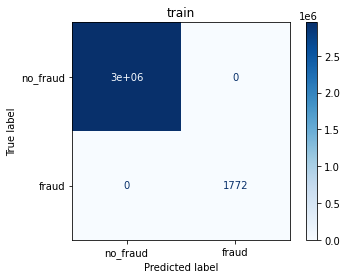

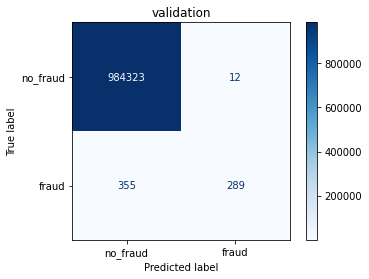

In [75]:
evaluate_model(knn_model_si, title='Knn', show_cm=True)

In [77]:
rf_clf = RandomForestClassifier(random_state=42)
parameters = {'n_estimators': [10, 20], 
              'max_depth':[10, 15, 20],
              'max_features': [7, 11]}

rf_grid_search = GridSearchCV(rf_clf, parameters,scoring = 'f1' , refit=True, verbose=1)
rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', rf_grid_search),
])

rf_model.fit(train, train.is_fraud)

print("Mejores parámetros encontrados:")
print(rf_grid_search.best_params_)
print("Puntuación media en el conjunto de validación:")
print(rf_grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros encontrados:
{'max_depth': 20, 'max_features': 11, 'n_estimators': 10}
Puntuación media en el conjunto de validación:
0.7437995112045948


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.999890,0.992512,0.822799,0.899722
validation,0.999741,0.927473,0.655280,0.767971


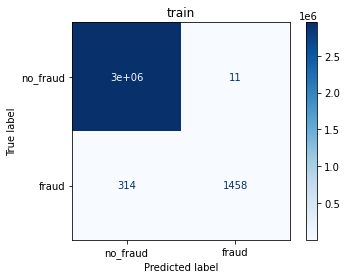

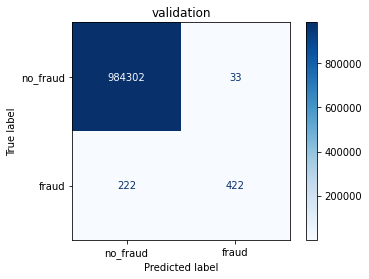

In [78]:
evaluate_model(rf_model, title='Random Forest', show_cm=True)

***Entrenamiento con PCA
aqui realizaremos entrenamiento con PCA y los modelos anteriores utilizando los mejores hiperparámetros encontrados 

In [29]:
import time
lr_best_params = {'C': 10.0, 'penalty': 'l2'}

lr_model_pca = LogisticRegression(**lr_best_params, random_state=42)
lr_pipeline_pca = Pipeline([
    ('mapper', mapper),
    ('pca', PCA(n_components=0.95)),
    ('classifier', lr_model_pca),
])

start = time.time()
lr_pipeline_pca.fit(train, train.is_fraud)
stop = time.time()
print(f"LR Training time w/ PCA: {stop - start}s")

LR Training time w/ PCA: 5.320409297943115s


'Logistic Regression with PCA'

,Accuracy,Precision,Recall,F1
train,0.999449,0.846890,0.099887,0.178698
validation,0.999417,0.926829,0.118012,0.209366


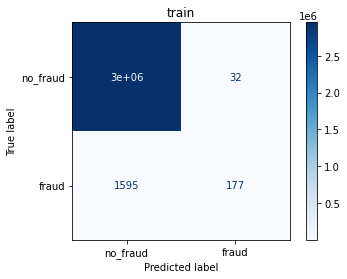

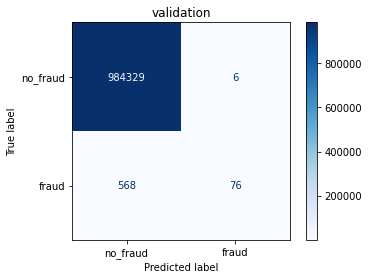

In [30]:
evaluate_model(lr_pipeline_pca, title='Logistic Regression with PCA', show_cm=True)

RANDOM FOREST CON PCA

In [31]:
rf_best_params = {'max_depth': 20, 'max_features': 11, 'n_estimators': 10}

rf_model_pca = RandomForestClassifier(**rf_best_params, random_state=42)
rf_pipeline_pca = Pipeline([
    ('mapper', mapper),
    ('pca', PCA(n_components=0.95)),
    ('classifier', rf_model_pca),
])

start = time.time()
rf_pipeline_pca.fit(train, train.is_fraud)
stop = time.time()
print(f"RF Training time w/ PCA: {stop - start}s")

RF Training time w/ PCA: 362.84108686447144s


'Random Forest with PCA'

,Accuracy,Precision,Recall,F1
train,0.999726,0.998963,0.543454,0.703947
validation,0.999622,0.953333,0.444099,0.605932


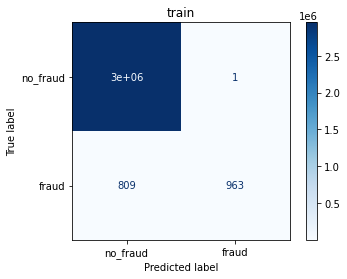

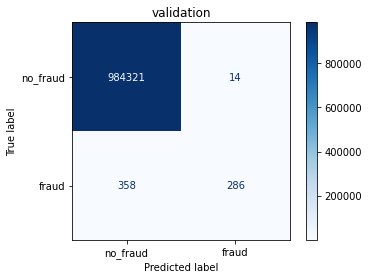

In [32]:
evaluate_model(rf_pipeline_pca, title='Random Forest with PCA', show_cm=True)

prueba con más profundidad

In [35]:
rf_best_params = {'max_depth': 25, 'max_features': 11, 'n_estimators': 10}
rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', RandomForestClassifier(**rf_best_params, random_state=42)),
])
rf_model.fit(train, train.is_fraud)

evaluate_model(rf_model, title='Random Forest')

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.999963,0.997606,0.940745,0.968342
validation,0.999747,0.907216,0.683230,0.779451


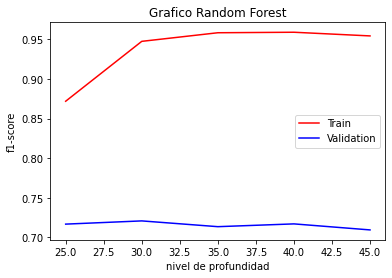

In [34]:
train_f1 =  []
eval_f1 = []
max_deep_list = list(range(25, 50,5))

for deep in max_deep_list:
    
    model_rf_maxdepth_curva = Pipeline([
    ('mapper', mapper),
    ('classifier', RandomForestClassifier(n_estimators=10, max_depth=deep, random_state=42)),
    ])
    
    arbol_rf=model_rf_maxdepth_curva    
    arbol_rf=arbol_rf.fit(train, train.is_fraud)
    y_train_pred = model_rf_maxdepth_curva.predict(train.drop(columns=['is_fraud']))
    y_val_pred = model_rf_maxdepth_curva.predict(validation.drop(columns=['is_fraud']))
    train_f1.append(metrics.f1_score( train.is_fraud, y_train_pred))
    eval_f1.append(metrics.f1_score(validation.is_fraud, y_val_pred))

# graficar los resultados.
plt.plot(max_deep_list, train_f1, color='r', label='Train')
plt.plot(max_deep_list, eval_f1, color='b', label='Validation')
plt.title('Grafico Random Forest')
plt.legend()
plt.ylabel('f1-score')
plt.xlabel('nivel de profundidad')
plt.show()

In [51]:
# Suponemos que frauds es tu DataFrame y 'is_fraud' la variable objetivo
num_records = len(frauds)
train_end = int(num_records * 0.6)
validation_end = int(num_records * 0.8)

# Crear índices para cada conjunto
train_indices = range(0, train_end)
validation_indices = range(train_end, validation_end)
test_indices = range(validation_end, num_records)

# Crear los conjuntos de datos
X_train, y_train = frauds.iloc[train_indices].drop(columns='is_fraud'), frauds.iloc[train_indices]['is_fraud']
X_validation, y_validation = frauds.iloc[validation_indices].drop(columns='is_fraud'), frauds.iloc[validation_indices]['is_fraud']
X_test, y_test = frauds.iloc[test_indices].drop(columns='is_fraud'), frauds.iloc[test_indices]['is_fraud']

#volviendo a unir
y_train.name = 'is_fraud'
train = pd.concat([X_train, y_train], axis=1)
y_validation.name = 'is_fraud'
validation = pd.concat([X_validation, y_validation], axis=1)
y_test.name = 'is_fraud'
test = pd.concat([X_test, y_test], axis=1)

# Puedes verificar los tamaños
print("Train size:", X_train.shape)
print("Validation size:", X_validation.shape)
print("Test size:", X_test.shape)

Train size: (2954937, 7)
Validation size: (984979, 7)
Test size: (984980, 7)


In [45]:
cant_fraud_train = (y_train == 1).sum()
print(cant_fraud_train)
cant_fraud_validation = (y_validation == 1).sum()
print(cant_fraud_validation)
cant_fraud_test = (y_test == 1).sum()
print(cant_fraud_test)

1148
279
1578


In [52]:
mapper_sorted = DataFrameMapper([
    (['step'], [StandardScaler()]),
    (['amount'], [StandardScaler()]),
    (['old_origin'], [StandardScaler()]),
    (['new_origin'], [StandardScaler()]),
    (['old_destination'], [StandardScaler()]),
    (['new_destination'], [StandardScaler()]),
    (['type'], [OneHotEncoder()])
])

# Lo entrenamos con train
mapper_sorted.fit(train)

DataFrameMapper(drop_cols=[],
                features=[(['step'], [StandardScaler()]),
                          (['amount'], [StandardScaler()]),
                          (['old_origin'], [StandardScaler()]),
                          (['new_origin'], [StandardScaler()]),
                          (['old_destination'], [StandardScaler()]),
                          (['new_destination'], [StandardScaler()]),
                          (['type'], [OneHotEncoder()])])

In [53]:
rf_best_params = {'max_depth': 20, 'max_features': 11, 'n_estimators': 10}

rf_model_pca_sorted = RandomForestClassifier(**rf_best_params, random_state=42)
rf_pipeline_pca = Pipeline([
    ('mapper', mapper_sorted),
    ('pca', PCA(n_components=0.95)),
    ('classifier', rf_model_pca_sorted),
])

start = time.time()
rf_pipeline_pca.fit(X_train, y_train)
stop = time.time()
print(f"RF Training time w/ PCA: {stop - start}s")

RF Training time w/ PCA: 327.31168365478516s


In [54]:
evaluate_model(rf_pipeline_pca, title='Random Forest con data set ordenado')

'Random Forest con data set ordenado'

,Accuracy,Precision,Recall,F1
train,0.999845,1.00000,0.601916,0.751495
validation,0.999763,0.64557,0.365591,0.466819


In [55]:
from sklearn.ensemble import GradientBoostingClassifier
boost_model = GradientBoostingClassifier(random_state=42)
model_gradient_boosted = Pipeline([
    ('mapper', mapper),
    ('classifier', boost_model),
    ])

start = time.time()
model_gradient_boosted.fit(train, train.is_fraud)

stop = time.time()
print(f"RF Training time w/ PCA: {stop - start}s")

RF Training time w/ PCA: 935.0034735202789s


In [56]:
evaluate_model(model_gradient_boosted, title='Gradient Boosting')

'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.999667,0.790036,0.193380,0.310707
validation,0.999741,0.676471,0.164875,0.265130


* Aplicar alguna técnica de feature engineering para mejorar los datos de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.